<a href="https://colab.research.google.com/github/agalvezm/ACE2_scRNAseq/blob/master/notebooks_countmatrices/E_MTAB_7407_ERS3861796.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# E-MTAB-7407_

In [1]:
# define the values for the analysis

# accession id for the data
id = "E-MTAB-7407"
samp_id = ["ERS3861796"]

# If only bam available files, set bam = True, Fill link and filename
bam = False

# If fastq links available but are not ffq links
fastq_ffqlinks = True

if not bam:

  # Copy and paste the links from the ACE2 scRNAseq datasets google  spreadsheet
  links_raw = "ftp://ftp.ebi.ac.uk/pub/databases/microarray/data/experiment/MTAB/E-MTAB-7407/FCAImmP7277553_S1_L001_R1_001.fastq.gz	ftp://ftp.ebi.ac.uk/pub/databases/microarray/data/experiment/MTAB/E-MTAB-7407/FCAImmP7277553_S1_L001_R2_001.fastq.gz"

  # Convert it to a list where each link is an element
  
  fastqs = links_raw.split()

no_samples = 1
tissue = ["liver"] * no_samples

cell_type = ["CD45-"] * no_samples

condition = ["female, 17 weeks gestation"] * no_samples


In [2]:
no_samples = 1

fastqs_per_sample = [2] 

sample_id = samp_id

database_id = [id] * no_samples

# tissue = [""] * no_samples

# cell_type = ["CD45+"] * no_samples

# condition = ["male, 8 weeks gestation"] * no_samples

species = ["human"] * no_samples

technology = ["10xv2"] * no_samples

paper = ["Sungnak et al 2020"] * no_samples

figure = ["Fig 1"] * no_samples


# Set string variables for kb functions

species_kb = species[0]

technology_kb = technology[0]



# Imports and installs

In [3]:
# install and import necessary software

# Install kb and scanpy
!pip -q install kb-python 
!pip -q install scanpy

import re
import os

# Setup

import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import scanpy as sc
from scipy import stats

from collections import OrderedDict
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.preprocessing import scale

from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import NeighborhoodComponentsAnalysis
from matplotlib import cm
from matplotlib.lines import Line2D

def nd(arr):
    return np.asarray(arr).reshape(-1)
def yex(ax):
    lims = [np.min([ax.get_xlim(), ax.get_ylim()]),
            np.max([ax.get_xlim(), ax.get_ylim()])]

    # now plot both limits against eachother
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    return ax

def trim_axs(axs, N):
    """little helper to massage the axs list to have correct length..."""
    axs = axs.flat
    for ax in axs[N:]:
        ax.remove()
    return axs[:N]

import warnings
warnings.filterwarnings('ignore')

fsize=20

plt.rcParams.update({'font.size': fsize})
%config InlineBackend.figure_format = 'retina'

     |████████████████████████████████| 59.1MB 128kB/s 
     |████████████████████████████████| 51kB 5.8MB/s 
     |████████████████████████████████| 133kB 52.0MB/s 
     |████████████████████████████████| 10.3MB 36.2MB/s 
     |████████████████████████████████| 13.2MB 35.1MB/s 
     |████████████████████████████████| 112kB 50.8MB/s 
     |████████████████████████████████| 81kB 8.9MB/s 
     |████████████████████████████████| 1.2MB 40.1MB/s 
     |████████████████████████████████| 51kB 5.1MB/s 
     |████████████████████████████████| 71kB 6.3MB/s 


# Downloads: (bam (if bam) and index

In [4]:
if bam:

  # Install bamtofastq from 10x website (only bam files available)
  !wget http://cf.10xgenomics.com/misc/bamtofastq-1.2.0
  !chmod +x bamtofastq-1.2.0
  # Download the bam file
  !wget -- continue ${BAM_LINK}




In [5]:
if bam:
  # Convert to fastq
  !./bamtofastq-1.2.0 --reads-per-fastq=500000000 $bam_filename ./fastqs\

  # Remove original bam file to save space
  !rm $bam_filename


In [6]:
# Store fastq names on a list

if bam:
  # cd into fastqs folder
  %cd /content/fastqs

  #store the name of the folder generated by bamtofastq
  _filename = os.listdir()[0]

  # cd into that folder
  %cd $_filename

  # store fastq names in a list
  fastqs = os.listdir()


  # Remove I1 and R3 reads not relevant for our analysis

  # Initialize list containing elements to remove
  remov_elem = []

  print ("\n\nThis is the complete list of fastqs:\n -----------")
  for elem in fastqs:
    print (elem)

  # Search index (I1 or R3) fastqs and remove them from list
  for elem in fastqs:
    if re.search("_R3_", elem) or re.search("_I1_", elem):
      remov_elem = remov_elem +[elem]

  fastqs = [elem for elem in fastqs if elem not in remov_elem] 

  print ("\n\nThis is the filtered list of fastqs:\n -----------")
  for elem in fastqs:
    print (elem)


In [7]:
# Remove fastqs that wont be analyzed to save space
if bam:
  for elem in remov_elem:
    !rm $elem

In [8]:
if bam:
  # sort fastqs alphabetically to get R1 and R2 in order
  fastqs = sorted(fastqs)

In [9]:
# wget fastqs from non ffq links in fastqs folder
if not bam and not fastq_ffqlinks:
  !mkdir fastqs
  %cd fastqs
  for link in fastqs:
    !wget $link --continue

  # update fastqs variable with name of files
  fastqs = sorted(os.listdir())

In [10]:
if bam:
  # Download the corresponding Kallisto index to folder containing fastqs
  !kb ref -d $species_kb -i index.idx -g t2g.txt -f1 transcriptome.fasta

if not bam and fastq_ffqlinks:
  %cd /content

  # Download the corresponding Kallisto index to content folder
  !kb ref -d $species_kb -i index.idx -g t2g.txt -f1 transcriptome.fasta

if not bam and not fastq_ffqlinks:
  %cd /content/fastqs

  # Download the corresponding Kallisto index to fastq folder
  !kb ref -d $species_kb -i index.idx -g t2g.txt -f1 transcriptome.fasta

/content
[2021-04-16 19:40:27,563]    INFO Downloading files for human from https://caltech.box.com/shared/static/v1nm7lpnqz5syh8dyzdk2zs8bglncfib.gz to tmp/v1nm7lpnqz5syh8dyzdk2zs8bglncfib.gz
100% 2.23G/2.23G [01:29<00:00, 26.7MB/s]
[2021-04-16 19:41:58,663]    INFO Extracting files from tmp/v1nm7lpnqz5syh8dyzdk2zs8bglncfib.gz


In [11]:
# Check to make sure the metadata is in the right order after sorting
print(fastqs)

['ftp://ftp.ebi.ac.uk/pub/databases/microarray/data/experiment/MTAB/E-MTAB-7407/FCAImmP7277553_S1_L001_R1_001.fastq.gz', 'ftp://ftp.ebi.ac.uk/pub/databases/microarray/data/experiment/MTAB/E-MTAB-7407/FCAImmP7277553_S1_L001_R2_001.fastq.gz']


# Process fastq files (modify kb command according to fastqs list)


In [12]:
fastqs

['ftp://ftp.ebi.ac.uk/pub/databases/microarray/data/experiment/MTAB/E-MTAB-7407/FCAImmP7277553_S1_L001_R1_001.fastq.gz',
 'ftp://ftp.ebi.ac.uk/pub/databases/microarray/data/experiment/MTAB/E-MTAB-7407/FCAImmP7277553_S1_L001_R2_001.fastq.gz']

In [13]:
# Specify the sample number and whether they are paired-ended


if no_samples == 1:

  # Write the kb count command as a string with all fastqs of the list as an input
  cmd = "kb count --h5ad -i index.idx -g t2g.txt -x " + technology_kb + " -o output" + sample_id[0] + " "\
  + "--filter bustools -t 2 --overwrite " + "'" +  "' '".join(fastqs) + "'"
  
  # Execute it
  !$cmd

# If more than one sample, iterate through fastqs accordingly
else:

  # Initializa counter for fastq files
  j = 0

  # Loop over samples for analysis
  for i in range(no_samples):

    fastqs_to_analyze = fastqs[j:j + fastqs_per_sample[i]]
    # Write the kb count command as a string
    cmd = "kb count --h5ad -i ../index.idx -g ../t2g.txt -x " + technology_kb + " -o output" + sample_id[i] + " \
    --filter bustools -t 2 --overwrite " + "'" +  "' '".join(fastqs_to_analyze) + "'"

    # Execute it
    !$cmd

    # Update j to move to the next set of fastq
    j = j + fastqs_per_sample[i]







[2021-04-16 19:42:38,184]    INFO Piping ftp://ftp.ebi.ac.uk/pub/databases/microarray/data/experiment/MTAB/E-MTAB-7407/FCAImmP7277553_S1_L001_R1_001.fastq.gz to outputERS3861796/tmp/FCAImmP7277553_S1_L001_R1_001.fastq.gz
[2021-04-16 19:42:38,187]    INFO Piping ftp://ftp.ebi.ac.uk/pub/databases/microarray/data/experiment/MTAB/E-MTAB-7407/FCAImmP7277553_S1_L001_R2_001.fastq.gz to outputERS3861796/tmp/FCAImmP7277553_S1_L001_R2_001.fastq.gz
[2021-04-16 19:42:38,187]    INFO Using index index.idx to generate BUS file to outputERS3861796 from
[2021-04-16 19:42:38,188]    INFO         outputERS3861796/tmp/FCAImmP7277553_S1_L001_R1_001.fastq.gz
[2021-04-16 19:42:38,188]    INFO         outputERS3861796/tmp/FCAImmP7277553_S1_L001_R2_001.fastq.gz
Exception in thread Thread-1:
Traceback (most recent call last):
  File "/usr/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwa

# Load unfiltered matrix and assign filters to each matrix individually

## Load the unfiltered matrix (check dimensions)

In [14]:
# Define dict to store data
results = {}


In [15]:
# load the unfiltered matrix
for i in range(no_samples):
  results[sample_id[i]] = anndata.read_h5ad("output" + sample_id[i] + "/counts_unfiltered/adata.h5ad")
  results[sample_id[i]].var["gene_id"] = results[sample_id[i]].var.index.values

  t2g = pd.read_csv("t2g.txt", header=None, names=["tid", "gene_id", "gene_name"], sep="\t")
  t2g.index = t2g.gene_id
  t2g = t2g.loc[~t2g.index.duplicated(keep='first')]

  results[sample_id[i]].var["gene_name"] = results[sample_id[i]].var.gene_id.map(t2g["gene_name"])
  results[sample_id[i]].var.index = results[sample_id[i]].var["gene_name"]
  print("The unfiltered matrix " + sample_id[i] + " contains {} cells by {} genes".format(len(results[sample_id[i]].obs), len(results[sample_id[i]].var)))

  results[sample_id[i]].obs["cell_counts"] = results[sample_id[i]].X.sum(axis=1)
  results[sample_id[i]].var["gene_counts"] = nd(results[sample_id[i]].X.sum(axis=0))

  results[sample_id[i]].obs["n_genes"] = nd((results[sample_id[i]].X>0).sum(axis=1))
  results[sample_id[i]].var["n_cells"] = nd((results[sample_id[i]].X>0).sum(axis=0))

  mito_genes = results[sample_id[i]].var_names.str.startswith("MT-" or "mt-") 
  results[sample_id[i]].obs["percent_mito"] = results[sample_id[i]][:,mito_genes].X.sum(axis=1)/results[sample_id[i]].X.sum(axis=1)*100

  # Changing the name of the index is necessary to write the file (it won't work with duplicated names)
  results[sample_id[i]].var.index.name = "index"



The unfiltered matrix ERS3861796 contains 138029 cells by 60623 genes


## Assign filters for each matrix individually

In [16]:
# Modify this manually to change sample after having assigned the "expected_num_cells" and "mito_criteria" parameters
samp_n = 0


# Filtering criteria
cell_threshold = 100
gene_threshold = 3

mito_criteria = 30

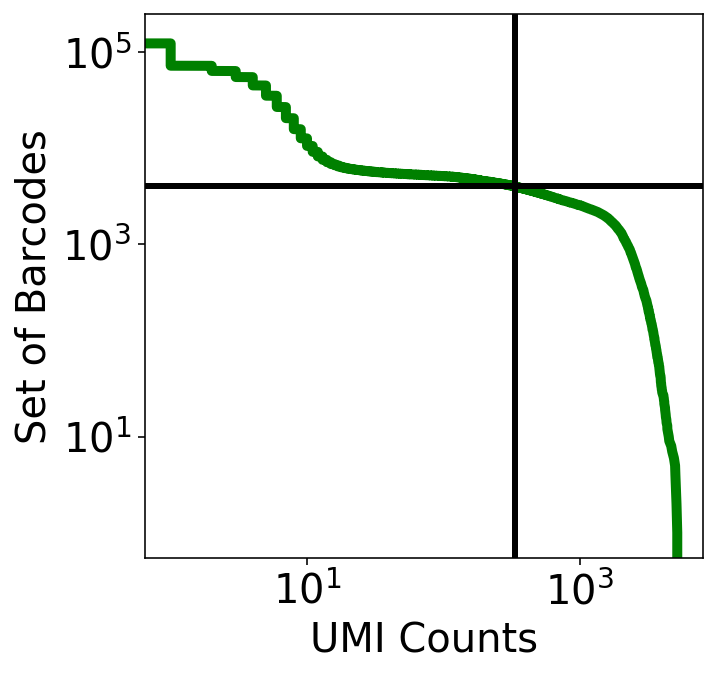

Cells were filtered down to 4000 with at least 334.0 UMIs


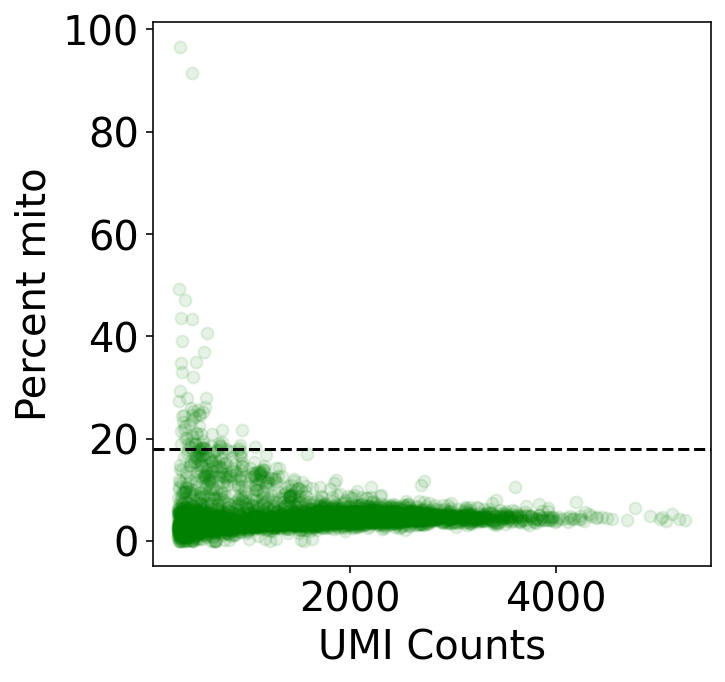

We select 18 % as the mitochondrial content threshold


In [20]:

expected_num_cells = 4000#@param {type:"integer"}
knee = np.sort(nd(results[sample_id[samp_n]].X.sum(axis=1)))[::-1]

fig, ax = plt.subplots(figsize=(5, 5))

x = knee
y = range(len(knee))

ax.loglog(x, y, linewidth=5, color="g")

ax.axvline(x=knee[expected_num_cells], linewidth=3, color="k")
ax.axhline(y=expected_num_cells, linewidth=3, color="k")

ax.set_xlabel("UMI Counts")
ax.set_ylabel("Set of Barcodes")

plt.show()

cell_threshold = knee[expected_num_cells]

results["cell_threshold" + sample_id[samp_n]] = knee[expected_num_cells]

print ("Cells were filtered down to " + str(expected_num_cells) + " with at least " + str(cell_threshold) + " UMIs")


mito_criteria = 18#@param {type:"integer"}
results["mito_criteria" + sample_id[samp_n]] = mito_criteria

fig, ax = plt.subplots(figsize=(5,5))


x = nd(results[sample_id[samp_n]].obs["cell_counts"][results[sample_id[samp_n]].obs["cell_counts"] > cell_threshold])
y = nd(results[sample_id[samp_n]].obs["percent_mito"][results[sample_id[samp_n]].obs["cell_counts"] > cell_threshold])

ax.scatter(x, y, color="green", alpha=0.1)

ax.axhline(y=mito_criteria, linestyle="--", color="k")


ax.set_xlabel("UMI Counts")
ax.set_ylabel("Percent mito")


plt.show()

print("We select " + str(mito_criteria) + " % as the mitochondrial content threshold")

# Filter matrix

In [21]:
for i in range(no_samples):
  results[sample_id[i]].obs["pass_count_filter"] = results[sample_id[i]].obs["cell_counts"] > results["cell_threshold" + sample_id[i]]
  results[sample_id[i]].obs["pass_mito_filter"] = results[sample_id[i]].obs.percent_mito < results["mito_criteria" + sample_id[i]]
  results[sample_id[i]].var["pass_gene_filter"] = results[sample_id[i]].var["n_cells"] > gene_threshold

  cell_mask = np.logical_and(results[sample_id[i]].obs["pass_count_filter"].values, results[sample_id[i]].obs["pass_mito_filter"].values)
  gene_mask = results[sample_id[i]].var["pass_gene_filter"].values

  print("Current Shape: {:,} cells x {:,} genes".format(results[sample_id[i]].shape[0], results[sample_id[i]].shape[1]))
  print("    New shape: {:,} cells x {:,} genes".format(cell_mask.sum(), gene_mask.sum()))
  results["data_" + sample_id[i]] = results[sample_id[i]][cell_mask, gene_mask]

Current Shape: 138,029 cells x 60,623 genes
    New shape: 3,932 cells x 19,257 genes


# Anotate and write the Anndata object

In [22]:
for i in range(no_samples):


  results["data_" + sample_id[i]].uns["database_id"] = database_id[i]

  results["data_" + sample_id[i]].uns["tissue"] = tissue[i]

  results["data_" + sample_id[i]].uns["cell_type"] = cell_type[i]

  results["data_" + sample_id[i]].uns["sample_id"] = sample_id[i]

  results["data_" + sample_id[i]].uns["condition"] = condition[i]

  results["data_" + sample_id[i]].uns["species"] = species[i]

  results["data_" + sample_id[i]].uns["technology"] = technology[i]

  results["data_" + sample_id[i]].uns["paper"] = paper[i]

  results["data_" + sample_id[i]].uns["figure"] = figure[i]


%cd /content

for i in range(no_samples):

  results["data_" + sample_id[i]].write("result" + sample_id[i])

Trying to set attribute `.uns` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
... storing 'gene_name' as categorical


/content
